## Importar bibliotecas

In [17]:
import os
import re
import csv
from datetime import datetime
import pytz
from shapely.geometry import shape, Point
import geopandas as gpd
import pandas as pd
from h3 import h3
from geopy.distance import geodesic

## Obtener rutas de los Datasets

In [86]:
# Obtener la ruta de la carpeta del notebook
notebook_folder = os.getcwd()
root_project = os.path.abspath(os.path.join(notebook_folder, '..'))
dataset_logs = os.path.abspath(os.path.join(root_project, 'Datos', 'Logs'))
trufi_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Registros de Trufi App'))
municipios_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Poligonos de Cochabamba','region_cochabamba_2018.geojson'))
clima_datos = os.path.abspath(os.path.join(root_project, 'Datos', 'Datos del clima','weather.csv'))

# Definir la zona horaria de La Paz, Bolivia
la_paz_timezone = pytz.timezone('America/La_Paz')

def obtener_archivos_ordenados(dataset_logs):
    # Obtener la lista de archivos y ordenarlos según el prefijo numérico
    files = os.listdir(dataset_logs)
    file_pattern = re.compile(r'^\d{2}-')
    log_files = [file for file in files if file_pattern.match(file)]
    log_files.sort(key=lambda x: int(x.split('-')[0]))
    return log_files

# Guardar la información en un archivo CSV
csv_file_path = os.path.join(dataset_logs, 'route_info.csv')

# Obtener la lista de archivos y ordenarlos según el prefijo numérico
logs_ordenados = obtener_archivos_ordenados(dataset_logs)
logs_ordenados

['02-12Sep2022-20Oct2022.log',
 '03-25_11_2022access.log',
 '04-08_12_2022access.log',
 '05-15_05_2023_access.log',
 '07-27_07_2023_access.log',
 '08-28_08_2023_access.log',
 '09-06_12_2023_access.log',
 '10-26_12_2023_access.log']

## Obtener resumen de logs Trufi-App

In [72]:
def obtener_resumen_archivo(file_path):
    # Obtener el número de líneas y el tamaño del archivo
    num_lineas = sum(1 for line in open(file_path, 'r'))
    tamano_archivo = os.path.getsize(file_path)  # Tamaño en bytes

    return num_lineas, tamano_archivo

# Lista para almacenar los resúmenes de cada archivo
resumenes_archivos = []

# Imprimir las descripciones de los logs
for log_file in logs_ordenados:
    file_path = os.path.join(dataset_logs, log_file)
    
    num_lineas, tamano_archivo = obtener_resumen_archivo(file_path)

    # Almacenar el resumen en la lista
    resumen = log_file, num_lineas, tamano_archivo
    resumenes_archivos.append(resumen)
resumenes_archivos

[('02-12Sep2022-20Oct2022.log', 4415730, 698783494),
 ('03-25_11_2022access.log', 5760606, 907118103),
 ('04-08_12_2022access.log', 2486201, 390522085),
 ('05-15_05_2023_access.log', 38737699, 6081361303),
 ('07-27_07_2023_access.log', 19332797, 3039911930),
 ('08-28_08_2023_access.log', 7712177, 1213088699),
 ('09-06_12_2023_access.log', 7976390, 1261354587),
 ('10-26_12_2023_access.log', 62182864, 9686722345)]

In [73]:
# Imprimir resúmenes individuales para la segunda columna (num_lineas)
for nombre_archivo, num_lineas, _ in resumenes_archivos:
    print(f"{nombre_archivo}: {num_lineas} líneas")

# Imprimir el total de líneas
total_lineas = sum(num_lineas for _, num_lineas, _ in resumenes_archivos)
print(f"Total de líneas en todos los archivos: {total_lineas} líneas.\n")

# Imprimir resúmenes individuales para la tercera columna (tamano_archivo)
for nombre_archivo, _, tamano_archivo in resumenes_archivos:
    print(f"{nombre_archivo}: Tamaño: {tamano_archivo} bytes")

# Imprimir el total de tamaños
total_tamano = sum(tamano_archivo for _, _, tamano_archivo in resumenes_archivos)
print(f"Tamaño total de todos los archivos: {total_tamano} bytes.")
print("Proceso completado.")


02-12Sep2022-20Oct2022.log: 4415730 líneas
03-25_11_2022access.log: 5760606 líneas
04-08_12_2022access.log: 2486201 líneas
05-15_05_2023_access.log: 38737699 líneas
07-27_07_2023_access.log: 19332797 líneas
08-28_08_2023_access.log: 7712177 líneas
09-06_12_2023_access.log: 7976390 líneas
10-26_12_2023_access.log: 62182864 líneas
Total de líneas en todos los archivos: 148604464 líneas.

02-12Sep2022-20Oct2022.log: Tamaño: 698783494 bytes
03-25_11_2022access.log: Tamaño: 907118103 bytes
04-08_12_2022access.log: Tamaño: 390522085 bytes
05-15_05_2023_access.log: Tamaño: 6081361303 bytes
07-27_07_2023_access.log: Tamaño: 3039911930 bytes
08-28_08_2023_access.log: Tamaño: 1213088699 bytes
09-06_12_2023_access.log: Tamaño: 1261354587 bytes
10-26_12_2023_access.log: Tamaño: 9686722345 bytes
Tamaño total de todos los archivos: 23278862546 bytes.
Proceso completado.


In [76]:
# Expresiones regulares para extraer información específica de las solicitudes de rutas
route_pattern_with_id = re.compile(r'GET /otp/plan\?fromPlace=([-0-9.]+)%2C([-0-9.]+)&toPlace=([-0-9.]+)%2C([-0-9.]+).*?Trufi/.*?/([a-f0-9-]+)')
route_pattern_without_id = re.compile(r'GET /otp/plan\?fromPlace=([-0-9.]+)%2C([-0-9.]+)&toPlace=([-0-9.]+)%2C([-0-9.]+)')

# Contadores para las líneas de solicitudes de rutas
count_solicitudes_con_id = 0
count_solicitudes_sin_id = 0

# Iterar sobre las líneas de los archivos
for log_file in logs_ordenados:
    file_path = os.path.join(dataset_logs, log_file)
    
    with open(file_path, 'r') as f:
        for line in f:
            # Verificar si la línea es una solicitud de ruta con o sin ID
            if route_pattern_with_id.search(line):
                count_solicitudes_con_id += 1
            elif route_pattern_without_id.search(line):
                count_solicitudes_sin_id += 1

In [77]:

# Imprimir resultados
print(f"Solicitudes de rutas con ID: {count_solicitudes_con_id} líneas.")
print(f"Solicitudes de rutas sin ID: {count_solicitudes_sin_id} líneas.")
print(f"Total: {count_solicitudes_sin_id+count_solicitudes_con_id} líneas.")


Solicitudes de rutas con ID: 1577854 líneas.
Solicitudes de rutas sin ID: 78 líneas.
Total: 1577932 líneas.


## Obtener datos de divisiones geograficas de Cochabamba

Primeras filas del GeoDataFrame:
     id  objectid    c_ut  DEPARTAMEN      PROVINCIA  \
0    61      2515  030201  Cochabamba        Campero   
1    72       789  031402  Cochabamba         Punata   
2    88       805  030403  Cochabamba   Esteban Arze   
3    80       797  030703  Cochabamba       Capinota   
4    82       799  030701  Cochabamba       Capinota   
5    83       800  030601  Cochabamba          Arque   
6   101       819  031403  Cochabamba         Punata   
7   242       977  030203  Cochabamba        Campero   
8     4       725  030901  Cochabamba    Quillacollo   
9     5       726  031001  Cochabamba        Chapare   
10    6       727  030903  Cochabamba    Quillacollo   
11    7       728  030905  Cochabamba    Quillacollo   
12    8       729  030902  Cochabamba    Quillacollo   
13    9       730  030904  Cochabamba    Quillacollo   
14   10      1871  030401  Cochabamba   Esteban Arze   
15   11      1087  031201  Cochabamba       Carrasco   
16   31       7

<Axes: >

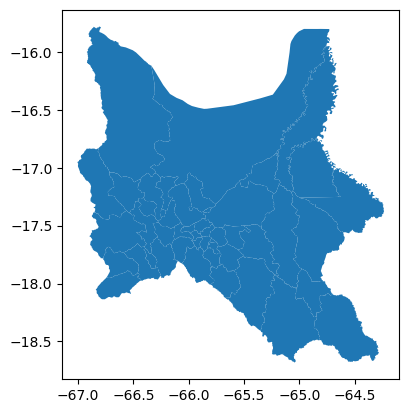

In [85]:

# Cargar el GeoDataFrame desde el GeoJSON
gdf = gpd.read_file(municipios_datos)

# Imprimir las primeras filas del GeoDataFrame
print("Primeras filas del GeoDataFrame:")
print(gdf.head(50))

# Visualizar el GeoDataFrame
gdf.plot()


## Inspeccionar datos del clima

In [92]:

df = pd.read_csv(clima_datos)

# Imprimir las primeras filas del DataFrame
print("Primeras filas del DataFrame:")
print(df.head(),df.tail())

# Obtener información básica sobre el DataFrame
print("\nInformación del DataFrame:")
print(df.info())

# Obtener estadísticas descriptivas sobre las columnas numéricas
print("\nEstadísticas descriptivas:")
print(df.describe())


Primeras filas del DataFrame:
         name             datetime  temp  feelslike  dew  humidity  precip  \
0  Cochabamba  2022-09-08T00:00:00  13.0       13.0  2.0     47.19     0.0   
1  Cochabamba  2022-09-08T01:00:00  12.0       12.0  1.0     46.90     0.0   
2  Cochabamba  2022-09-08T02:00:00  12.2       12.2  1.8     49.17     0.0   
3  Cochabamba  2022-09-08T03:00:00  10.0       10.0  1.0     53.56     0.0   
4  Cochabamba  2022-09-08T04:00:00  10.0       10.0  1.0     53.56     0.0   

   precipprob preciptype  snow  ...  sealevelpressure  cloudcover  visibility  \
0         0.0        NaN     0  ...            1021.0         0.0        10.0   
1         0.0        NaN     0  ...            1021.0         0.0        10.0   
2         0.0        NaN     0  ...            1020.0         5.0        12.5   
3         0.0        NaN     0  ...            1020.0         0.0        10.0   
4         0.0        NaN     0  ...            1020.0         0.0        10.0   

   solarradiat